In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import *
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.stats.diagnostic import het_breuschpagan

In [14]:
Data = pd.read_csv("Car_Crash_Cleaned_AADT.csv")

In [15]:
def PredictionReport(X_values: pd.DataFrame, Y_values: pd.DataFrame, classifier: str = "Gaussian") -> None:
    Observation = X_values.to_numpy()
    Results = Y_values.to_numpy().ravel()
    X_train, X_test, y_train, y_test = train_test_split(Observation, Results, test_size=0.2, random_state=0)
    
    gnb = GaussianNB()
    if classifier == "Multinomial":
        gnb = MultinomialNB()
    elif classifier == "Complement":
        gnb = ComplementNB()
    elif classifier == "Categorical":
        gnb = CategoricalNB()
        
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    print("Number of mislabeled points out of a total %d points : %d"
          % (X_test.shape[0], (y_test != y_pred).sum()))
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred)
    
    # Print classification report
    print("\nClassification Report:")
    print(class_report)
    values_index = Y_values['Injury Severity'].unique().tolist()
    values_index.sort()
    cm_df = pd.DataFrame(conf_matrix,
                     index = values_index, 
                     columns = values_index)
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

    unique_values, counts = np.unique(y_pred, return_counts=True)
    print("Predicted values:")
    for value, count in zip(unique_values, counts):
        print(f"{value} occurs {count} times")
    unique_values, counts = np.unique(y_test, return_counts=True)
    
    print("\nActual values:")
    for value, count in zip(unique_values, counts):
        print(f"{value} occurs {count} times")

    return None

In [16]:
def Prepare_Data_for_Prediction(df) -> list:
    LightingCond = {'Dark-Street Lights On':3, 'Dark-No Street Lights':5, 'Daylight':1,
       'Unknown':1, 'Dark-Street Lights Off':4, 'Dawn':0,
       'Dark - Unknown Lighting':5, 'Dusk':2, 'Other':1}

    WeatherCond = {'Clear':0,
              'Partly Cloudy': 1,
              'Overcast': 2,
              'Raining': 5,
              'Snowing': 6,
              'Sleet or Hail or Freezing Rain': 7,
              'Other':0, 'Severe Crosswind':4,
       'Fog or Smog or Smoke':3, 'Blowing Sand or Dirt or Snow':8}
    
    Known_Injury = df[(df["Injury Severity"] != "Unknown Injury Collision")]
    X = Known_Injury[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition', 'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]
    values = {"Lighting Condition": 'Unknown', "Weather Condition": 'Other', 'Passengers Involved':0.0, 'Commercial Carrier Involved':0.0,
       'School Bus Involved':0.0, 'Pedestrians Involved':0.0, 'Pedalcyclists Involved':0.0}
    X=X.fillna(value=values)
    X=X.dropna()
    Conditions = ['Weather Condition','Lighting Condition']
    for Condition in Conditions:
        use_list = []
        states = []
        if Condition == 'Weather Condition':
            use_dict = WeatherCond
            states = X['Weather Condition'].unique()
        else:
            use_dict = LightingCond
            states = X['Lighting Condition'].unique()
        for i in np.arange(X[Condition].unique().shape[0]):
            X.loc[X[Condition] == states[i], Condition] = use_dict[states[i]]
    Y = Data[['Injury Severity']].iloc[X.index.to_list()]

    return {"X": X, "Y":Y}

Number of mislabeled points out of a total 7722 points : 3951

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.50      0.04      0.08        71
  Minor Injury Collision       0.23      0.43      0.30      1665
     No Injury Collision       0.78      0.52      0.62      5819
Serious Injury Collision       0.04      0.16      0.06       167

                accuracy                           0.49      7722
               macro avg       0.39      0.29      0.27      7722
            weighted avg       0.64      0.49      0.54      7722



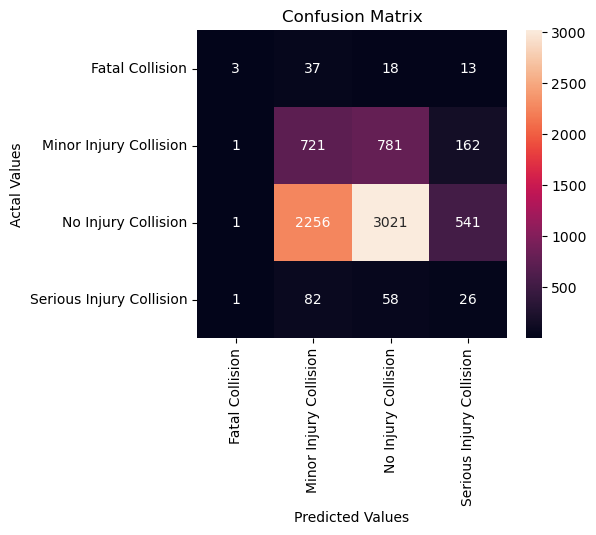

Predicted values:
Fatal Collision occurs 6 times
Minor Injury Collision occurs 3096 times
No Injury Collision occurs 3878 times
Serious Injury Collision occurs 742 times

Actual values:
Fatal Collision occurs 71 times
Minor Injury Collision occurs 1665 times
No Injury Collision occurs 5819 times
Serious Injury Collision occurs 167 times


In [17]:
PredictionReport(Prepare_Data(Data)["X"],Prepare_Data(Data)["Y"],"Complement")

In [18]:
def Prediction_Models() -> None:
    print("Using Categorical Naive Bayesian Classifier Algorithm")
    PredictionReport(Prepare_Data(Data)["X"],Prepare_Data(Data)["Y"],"Categorical")
    print("\n\nUsing Complement Naive Bayesian Classifier Algorithm")
    PredictionReport(Prepare_Data(Data)["X"],Prepare_Data(Data)["Y"],"Complement")

In [19]:
def AADT_Dist(df)-> None:
    print(df['AADT'].value_counts())
    plt.hist(df['AADT'].to_numpy(), bins = 100)
    plt.show
    print(st.mode(df['AADT'].to_numpy()))

Using Categorical Naive Bayesian Classifier Algorithm
Number of mislabeled points out of a total 7722 points : 1895

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.00      0.00      0.00        71
  Minor Injury Collision       0.37      0.01      0.02      1665
     No Injury Collision       0.76      1.00      0.86      5819
Serious Injury Collision       0.00      0.00      0.00       167

                accuracy                           0.75      7722
               macro avg       0.28      0.25      0.22      7722
            weighted avg       0.65      0.75      0.65      7722



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


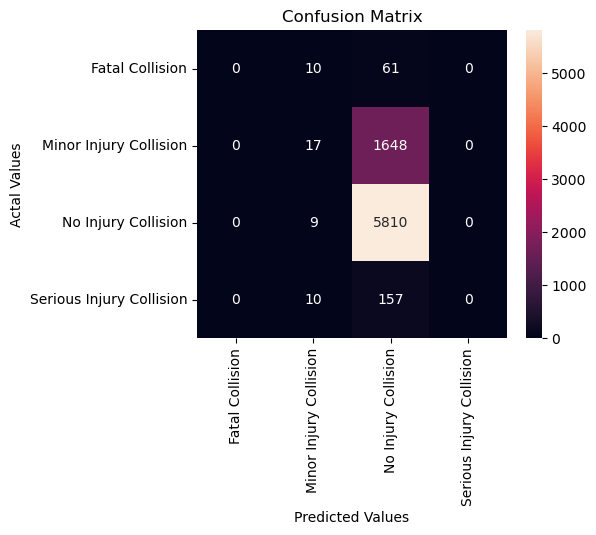

Predicted values:
Minor Injury Collision occurs 46 times
No Injury Collision occurs 7676 times

Actual values:
Fatal Collision occurs 71 times
Minor Injury Collision occurs 1665 times
No Injury Collision occurs 5819 times
Serious Injury Collision occurs 167 times


Using Complement Naive Bayesian Classifier Algorithm
Number of mislabeled points out of a total 7722 points : 3951

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.50      0.04      0.08        71
  Minor Injury Collision       0.23      0.43      0.30      1665
     No Injury Collision       0.78      0.52      0.62      5819
Serious Injury Collision       0.04      0.16      0.06       167

                accuracy                           0.49      7722
               macro avg       0.39      0.29      0.27      7722
            weighted avg       0.64      0.49      0.54      7722



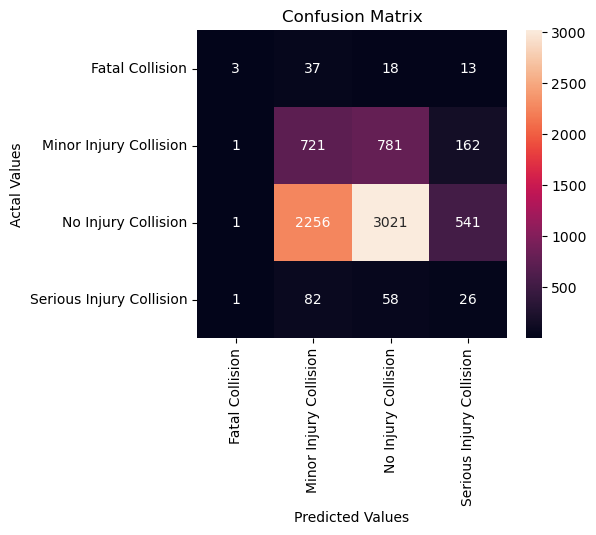

Predicted values:
Fatal Collision occurs 6 times
Minor Injury Collision occurs 3096 times
No Injury Collision occurs 3878 times
Serious Injury Collision occurs 742 times

Actual values:
Fatal Collision occurs 71 times
Minor Injury Collision occurs 1665 times
No Injury Collision occurs 5819 times
Serious Injury Collision occurs 167 times


In [20]:
Prediction_Models()

In [56]:
def LSData(df: pd.DataFrame, AADT: int = 0):

    RData = df[df['County'].notna() & df['Weather Condition'].notna() & df['Lighting Condition'].notna()]
    RData = RData.join(pd.get_dummies(RData[['County','Weather Condition','Lighting Condition']], dtype=float))
    RData = RData.drop(['County','Weather Condition','Lighting Condition',
        'Collision Report Number', 'Collision Date', 'City', 'Jurisdiction',
       'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number', 'Block Number',
                   'Object Struck', 'Mile Post', 'Associated State Road Number'], axis=1)

    if AADT in df['AADT'].unique():
        RData = RData[RData['AADT'] == AADT]
        RData = RData.drop(['AADT'], axis = 1)
    
    RData = RData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 0,
                                                 "Unknown Injury Collision":0,
                                  "Serious Injury Collision": 1, 
                                   'Fatal Collision': 1}})
    RData = RData.dropna()
    RY = RData['Injury Severity']
    RX = RData.drop(['Injury Severity'], axis=1)
    X_model = sm.add_constant(RX)
    model = sm.OLS(RY, X_model)
    results = model.fit(cov_type = "HC1")
    print(results.summary())
    return None

In [64]:
LSData(Data,5400)

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 67, but rank is 60
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2.729
Date:                Wed, 29 May 2024   Prob (F-statistic):           2.96e-11
Time:                        09:41:28   Log-Likelihood:                 1959.0
No. Observations:                3922   AIC:                            -3794.
Df Residuals:                    3860   BIC:                            -3405.
Df Model:                          61                                         
Covariance Type:                  HC1                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

AADT
5400.0      3922
190000.0     770
17000.0      562
23000.0      558
19000.0      514
            ... 
920.0          1
330.0          1
530.0          1
990.0          1
980.0          1
Name: count, Length: 336, dtype: int64
ModeResult(mode=5400.0, count=3922)


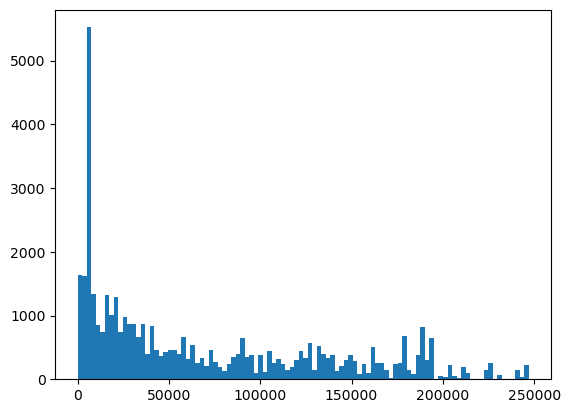

In [57]:
AADT_Dist(Data)

In [61]:
def LS_report(data):
    LSData(data)
    LSData(data,5400)

In [ ]:
LS_report

In [ ]:
PredictionReport(Prepare_Data(Data)["X"],Prepare_Data(Data)["Y"],"Complement")

In [31]:
Known_Injury_Data = Data[(Data["Injury Severity"] != "Unknown Injury Collision")]

In [32]:
Seattle_Known_Injury_Data = Known_Injury_Data[Known_Injury_Data["City"] == "Seattle"]

In [33]:
X = Known_Injury_Data[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition', 'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]

SeattleX = Seattle_Known_Injury_Data[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]

In [34]:
values = {"Lighting Condition": 'Unkown', "Weather Condition": 'Other', 'Passengers Involved':0.0, 'Commercial Carrier Involved':0.0,
       'School Bus Involved':0.0, 'Pedestrians Involved':0.0, 'Pedalcyclists Involved':0.0}
X=X.fillna(value=values)
X=X.dropna()
SeattleX = SeattleX.fillna(value=values)
SeattleX = SeattleX.dropna()

In [35]:
X["Weather Condition"].unique()

array(['Raining', 'Overcast', 'Clear', 'Snowing',
       'Sleet or Hail or Freezing Rain', 'Other', 'Severe Crosswind',
       'Fog or Smog or Smoke', 'Blowing Sand or Dirt or Snow'],
      dtype=object)

In [36]:
Conditions = ['Weather Condition','Lighting Condition']
Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
Lighting_Correspondance=[3,5,1,7,4,0,6,2,7]

In [37]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
        states = X['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = X['Lighting Condition'].unique()
    for i in np.arange(X[Condition].unique().shape[0]):
        X.loc[X[Condition] == states[i], Condition] = use_list[i]

In [38]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [1,2,0,4,5,6,3]
        states = SeattleX['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = SeattleX['Lighting Condition'].unique()
    for i in np.arange(SeattleX[Condition].unique().shape[0]):
        SeattleX.loc[X[Condition] == states[i], Condition] = use_list[i]

In [39]:
SeattleX['Weather Condition'].unique()

array(['Overcast', 'Raining', 'Clear', 'Sleet or Hail or Freezing Rain',
       'Fog or Smog or Smoke', 'Other', 'Snowing'], dtype=object)

In [40]:
Y = Data[['Injury Severity']].iloc[X.index.to_list()]
SeattleY = Data[['Injury Severity']].iloc[SeattleX.index.to_list()]

Number of mislabeled points out of a total 7722 points : 3954
0.48795648795648794
Confusion Matrix:
[[   3   38   18   12]
 [   1  724  779  161]
 [   1 2269 3015  534]
 [   1   82   58   26]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.50      0.04      0.08        71
  Minor Injury Collision       0.23      0.43      0.30      1665
     No Injury Collision       0.78      0.52      0.62      5819
Serious Injury Collision       0.04      0.16      0.06       167

                accuracy                           0.49      7722
               macro avg       0.39      0.29      0.27      7722
            weighted avg       0.64      0.49      0.54      7722



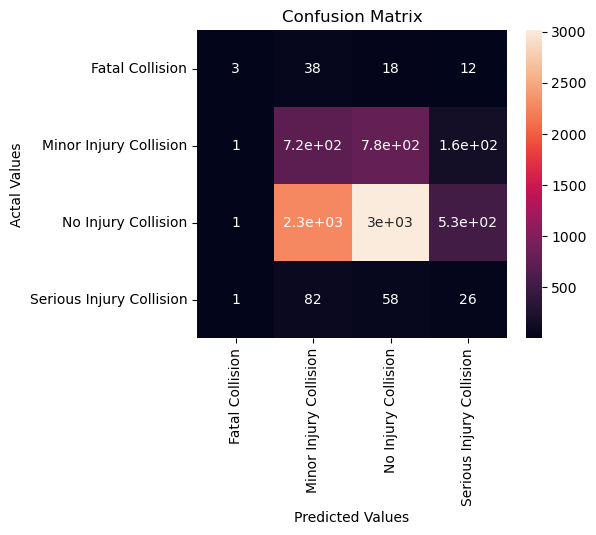

Predicted values:
Fatal Collision occurs 6 times
Minor Injury Collision occurs 3113 times
No Injury Collision occurs 3870 times
Serious Injury Collision occurs 733 times

Actual values:
Fatal Collision occurs 71 times
Minor Injury Collision occurs 1665 times
No Injury Collision occurs 5819 times
Serious Injury Collision occurs 167 times


In [16]:
PredictionReport(X.drop(['Weather Condition','Lighting Condition'],axis = 1),Y,"Complement")

In [ ]:
'Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition', 'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT'

Number of mislabeled points out of a total 7722 points : 3581
0.5362600362600363

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.11      0.03      0.04        71
  Minor Injury Collision       0.24      0.48      0.32      1665
     No Injury Collision       0.77      0.57      0.66      5819
Serious Injury Collision       0.08      0.01      0.02       167

                accuracy                           0.54      7722
               macro avg       0.30      0.27      0.26      7722
            weighted avg       0.64      0.54      0.57      7722



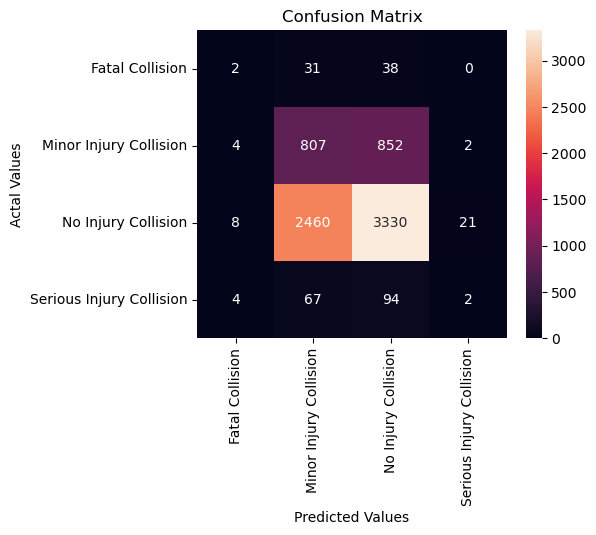

Predicted values:
Fatal Collision occurs 18 times
Minor Injury Collision occurs 3365 times
No Injury Collision occurs 4314 times
Serious Injury Collision occurs 25 times

Actual values:
Fatal Collision occurs 71 times
Minor Injury Collision occurs 1665 times
No Injury Collision occurs 5819 times
Serious Injury Collision occurs 167 times


In [45]:
PredictionReport(X.drop(['AADT'],axis = 1),Y,"Complement")

In [19]:
Y['Injury Severity'] = np.where((Y['Injury Severity'] == "No Injury Collision"), "No Injury", "Injury")


Number of mislabeled points out of a total 7722 points : 3631
0.5297850297850297

Classification Report:
              precision    recall  f1-score   support

      Injury       0.27      0.55      0.37      1903
   No Injury       0.78      0.52      0.63      5819

    accuracy                           0.53      7722
   macro avg       0.53      0.54      0.50      7722
weighted avg       0.66      0.53      0.56      7722



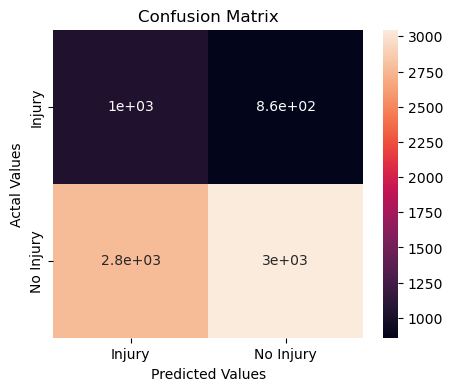

Predicted values:
Injury occurs 3816 times
No Injury occurs 3906 times

Actual values:
Injury occurs 1903 times
No Injury occurs 5819 times


In [23]:
PredictionReport(X,Y,"Complement")

Number of mislabeled points out of a total 1843 points : 710
0.6147585458491589
Confusion Matrix:
[[   0    4    7    0]
 [   0  113  304    0]
 [   0  381 1020    0]
 [   0    6    8    0]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.00      0.00      0.00        11
  Minor Injury Collision       0.22      0.27      0.25       417
     No Injury Collision       0.76      0.73      0.74      1401
Serious Injury Collision       0.00      0.00      0.00        14

                accuracy                           0.61      1843
               macro avg       0.25      0.25      0.25      1843
            weighted avg       0.63      0.61      0.62      1843



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


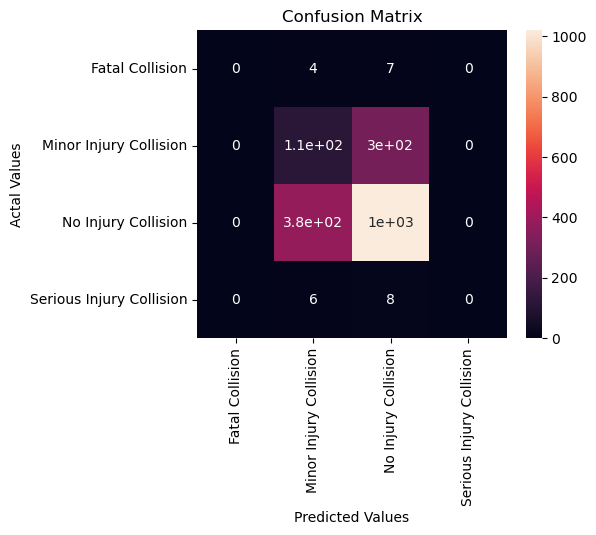

Predicted values:
Minor Injury Collision occurs 504 times
No Injury Collision occurs 1339 times

Actual values:
Fatal Collision occurs 11 times
Minor Injury Collision occurs 417 times
No Injury Collision occurs 1401 times
Serious Injury Collision occurs 14 times


In [500]:
PredictionReport(SeattleX,SeattleY,"Complement")

In [153]:
5400 in Data['AADT'].unique()

True

In [156]:
LSData(Data,5400)

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     12.48
Date:                Wed, 29 May 2024   Prob (F-statistic):          2.48e-109
Time:                        02:04:10   Log-Likelihood:                 1959.0
No. Observations:                3922   AIC:                            -3794.
Df Residuals:                    3860   BIC:                            -3405.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [ ]:
RX = RData[['Injury Severity','Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
    RX = RX.dropna()
    RY = RX['Injury Severity']
RX = RX[['Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
    

In [462]:
Known_Injury = df[(df["Injury Severity"] != "Unknown Injury Collision")]
RData = Known_Injury_Data[Known_Injury_Data['County'].notna() & Known_Injury_Data['Weather Condition'].notna() & Known_Injury_Data['Lighting Condition'].notna()]
RData = RData.join(pd.get_dummies(RData[['County','Weather Condition','Lighting Condition']], dtype=float))

In [463]:
RData = RData.drop(['County','Weather Condition','Lighting Condition','Associated S'
        'Collision Report Number', 'Collision Date', 'City', 'Jurisdiction',
       'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number', 'Block Number',
                   'Object Struck', 'Damage Threshold Met', 'Hit and Run', 'Mile Post'], axis=1)

In [464]:
#Distincting between sever and not severe injury
RegressData = RData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 0,
                                                 "Unknown Injury Collision":0,
                                  "Serious Injury Collision": 1, 
                                   'Fatal Collision': 1}})

In [465]:
RX = RegressData[['Injury Severity','Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]

In [466]:
RX = RX.dropna()

In [467]:
RY = RX['Injury Severity']
RX = RX[['Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]

In [468]:
X_model = sm.add_constant(RX)
model = sm.OLS(RY, X_model)
results = model.fit()

In [469]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     58.36
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        23:19:44   Log-Likelihood:                -32946.
No. Observations:               42360   AIC:                         6.602e+04
Df Residuals:                   42295   BIC:                         6.658e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [470]:
#Just finding between severe Injury or not
RegressData = RData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 0,
                                  "Serious Injury Collision": 1, 
                                   'Fatal Collision': 1}})
RX = RegressData[['Injury Severity','Associated State Road Number', 
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
RX = RX.dropna()
RY = RX['Injury Severity']
RX = RX[['Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
X_model = sm.add_constant(RX)
model = sm.OLS(RY, X_model)
results = model.fit()

In [471]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     56.82
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        23:19:45   Log-Likelihood:                 16762.
No. Observations:               42360   AIC:                        -3.339e+04
Df Residuals:                   42295   BIC:                        -3.283e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [510]:
SeattleRData = Seattle_Known_Injury_Data[Seattle_Known_Injury_Data['County'].notna() 
                                    & Seattle_Known_Injury_Data['Weather Condition'].notna() 
                                    & Seattle_Known_Injury_Data['Lighting Condition'].notna()]
SeattleRData = SeattleRData.join(pd.get_dummies(SeattleRData[['Weather Condition','Lighting Condition']], dtype=float))
SeattleRData = SeattleRData[SeattleRData["Injury Severity"] != "Unknown Injury Collision"]

In [511]:
SeattleRData = SeattleRData.drop(['County','Weather Condition','Lighting Condition',
        'Collision Report Number', 'Collision Date', 'City', 'Jurisdiction',
       'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number', 'Block Number',
                   'Object Struck', 'Damage Threshold Met', 'Hit and Run', 'Mile Post'], axis=1)

In [553]:
#Just finding between severe Injury or not
SeattleRegressData = SeattleRData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 0,
                                  "Serious Injury Collision": 1, 
                                   'Fatal Collision': 1}})
SRX = SeattleRegressData[['Injury Severity','Associated State Road Number', 
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 
       'Weather Condition_Raining', 
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
SRX = SRX.dropna()
SRY = SRX['Injury Severity']
SRX = SRX[['Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 
       'Weather Condition_Raining', 'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
SX_model = sm.add_constant(SRX)
model = sm.OLS(SRY, SX_model)
results = model.fit()

In [554]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.448
Date:                Tue, 28 May 2024   Prob (F-statistic):             0.0196
Time:                        01:53:11   Log-Likelihood:                 2661.8
No. Observations:                3780   AIC:                            -5320.
Df Residuals:                    3778   BIC:                            -5307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0236      0.004      5.432      0.0

In [50]:
SRw100 = Data["Associated State Road Number"].value_counts().head(57).index.to_list()

In [51]:
Data[Data["Associated State Road Number"] == 5].set_index(np.arange(len(Data[Data["Associated State Road Number"] == 5])))

,Collision Report Number,Collision Date,County,City,Jurisdiction,Agency,Primary Trafficway,Primary Road Number,Secondary Trafficway,Secondary Road Number,...,Object Struck,Damage Threshold Met,Hit and Run,Motor Vehicles Involved,Passengers Involved,Commercial Carrier Involved,School Bus Involved,Pedestrians Involved,Pedalcyclists Involved,AADT
0,EC07394,1/1/2022 3:20:00 AM,Pierce,Lakewood,State Road,State Patrol,84TH ST,NaN,SB I5,5.0,...,LIGHT POLE,1,1,1,0,0,0,0,0,173000.0
1,EC07169,1/1/2022 4:49:00 AM,King,Federal Way,State Road,State Patrol,NB I-5,5.0,SR-18,18.0,...,NaN,1,0,1,0,0,0,0,0,135000.0
2,EC07459,1/1/2022 5:52:00 AM,King,Seattle,State Road,State Patrol,INTERSTATE 5,5.0,MERCER ST,NaN,...,NaN,1,1,2,0,0,0,0,0,180000.0
3,EC07499,1/1/2022 12:28:00 PM,King,Seattle,State Road,State Patrol,SB I-5,5.0,NaN,NaN,...,NaN,1,1,3,1,0,0,0,0,190000.0
4,EC07499,1/1/2022 12:28:00 PM,King,Seattle,State Road,State Patrol,SB I-5,5.0,NaN,NaN,...,NaN,0,1,3,1,0,0,0,0,190000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12805,ED20647,12/30/2022 10:00:00 PM,King,Federal Way,State Road,State Patrol,SB I-5,5.0,S 320TH ST,NaN,...,Guardrail,1,1,2,1,0,0,0,0,178000.0
12806,ED20500,12/30/2022 10:30:00 PM,Cowlitz,Castle Rock,State Road,State Patrol,NB I-5,5.0,NB TOUTLE REST AREA,NaN,...,NaN,0,0,2,1,0,0,0,0,41000.0
12807,ED20500,12/30/2022 10:30:00 PM,Cowlitz,Castle Rock,State Road,State Patrol,NB I-5,5.0,NB TOUTLE REST AREA,NaN,...,NaN,1,0,2,1,0,0,0,0,41000.0
12808,ED21608,12/30/2022 11:33:00 PM,Cowlitz,Woodland,State Road,State Patrol,INTERSTATE 5,5.0,DIKE ROAD,NaN,...,Guardrail,1,0,1,0,0,0,0,0,67000.0


In [52]:
rng = np.random.default_rng(seed=12345)

In [56]:
import random

# Set the seed
random.seed(42)

def generate100Numbers(max: int, seed: int) -> np.array:
    random.seed(seed)
    random_numbers = random.sample(range(0, max), 100)  # Example: 10 unique random numbers between 1 and 100
    return np.array(random_numbers)


In [58]:
generate100Numbers(105,481)

array([ 86,  88,  60,  54,  84,  17,  59,  82,  39,  98,  79,  24,  15,
        43,  36,   4,  41,  11,  91,  31,   1,  96,  50,  33,  67,  23,
        46, 100,   6, 102,  21,  57,  94,  10,  34,  32,  68,  87,   0,
        75,  72,  28,  19,  26,  71,  63,  85,  61,  29,  66,  42,  20,
        64,  27,  83,  99,  48,   9,  25,  92,  14,  53,  93,  56,  47,
       101,  70,  97,  38,  44,  78, 104,  81,  90,  77,  37,  35,  12,
        74,  65,  40,  51,  22,  89,  30,   8, 103,  45,  69,  18,  16,
        76,  58,  73,   2,  62,   5,  13,  52,   3])

In [59]:
Data100s = Data[Data["Associated State Road Number"] == 0]
Data100s

,Collision Report Number,Collision Date,County,City,Jurisdiction,Agency,Primary Trafficway,Primary Road Number,Secondary Trafficway,Secondary Road Number,...,Object Struck,Damage Threshold Met,Hit and Run,Motor Vehicles Involved,Passengers Involved,Commercial Carrier Involved,School Bus Involved,Pedestrians Involved,Pedalcyclists Involved,AADT


In [60]:
Data100s = Data[Data["Associated State Road Number"] == 0]
for i in SRw100:
    Data100s = pd.concat([Data100s, Data[Data["Associated State Road Number"] == i].set_index(
        np.arange(len(Data[Data["Associated State Road Number"] == i]))).iloc[
        generate100Numbers(len(Data[Data["Associated State Road Number"] == i]),481)]])

Data100s = Data100s[(Data100s["Injury Severity"] != "Unknown Injury Collision")]

In [61]:
Data100s["Injury Severity"].unique()

array(['No Injury Collision', 'Minor Injury Collision',
       'Serious Injury Collision', 'Fatal Collision'], dtype=object)

In [62]:
X_100s = Data100s[['Associated State Road Number',"Injury Severity",'Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]

In [63]:
values = {"Lighting Condition": 'Unkown', "Weather Condition": 'Other', 'Passengers Involved':0.0, 'Commercial Carrier Involved':0.0,
       'School Bus Involved':0.0, 'Pedestrians Involved':0.0, 'Pedalcyclists Involved':0.0}
X_100s=X_100s.fillna(value=values)
X_100s=X_100s.dropna()

In [64]:
X_100s["Injury Severity"].unique()

array(['No Injury Collision', 'Minor Injury Collision',
       'Serious Injury Collision', 'Fatal Collision'], dtype=object)

In [65]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [0,7,2,3,5,4,0,6,1,8]
        states = X_100s['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = X_100s['Lighting Condition'].unique()
    for i in np.arange(X_100s[Condition].unique().shape[0]):
        X_100s.loc[X_100s[Condition] == states[i], Condition] = use_list[i]

In [66]:
Y_100s = X_100s[["Injury Severity"]]
X_100s = X_100s.drop(["Injury Severity"], axis = 1)

In [67]:
Y_100s["Injury Severity"].unique()

array(['No Injury Collision', 'Minor Injury Collision',
       'Serious Injury Collision', 'Fatal Collision'], dtype=object)

Number of mislabeled points out of a total 1108 points : 537
0.5153429602888087
Confusion Matrix:
[[  4   6   2   0]
 [  2 123 128   5]
 [  1 352 443  15]
 [  1  13  12   1]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.50      0.33      0.40        12
  Minor Injury Collision       0.25      0.48      0.33       258
     No Injury Collision       0.76      0.55      0.63       811
Serious Injury Collision       0.05      0.04      0.04        27

                accuracy                           0.52      1108
               macro avg       0.39      0.35      0.35      1108
            weighted avg       0.62      0.52      0.55      1108



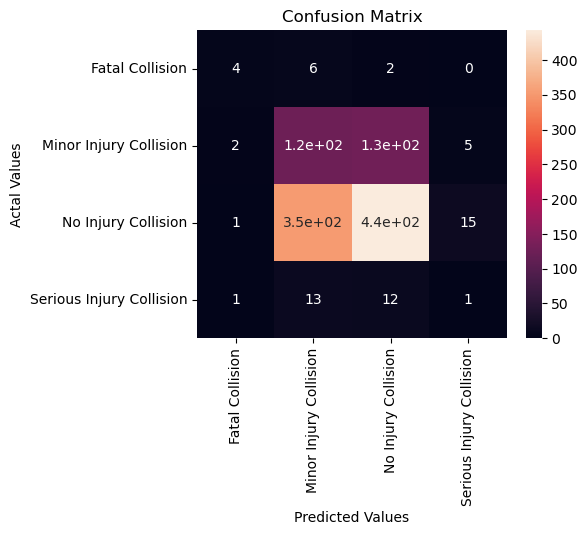

Predicted values:
Fatal Collision occurs 8 times
Minor Injury Collision occurs 494 times
No Injury Collision occurs 585 times
Serious Injury Collision occurs 21 times

Actual values:
Fatal Collision occurs 12 times
Minor Injury Collision occurs 258 times
No Injury Collision occurs 811 times
Serious Injury Collision occurs 27 times


In [71]:
PredictionReport(X_100s.drop(["AADT"], axis = 1),Y_100s,"Complement")

In [750]:
Data100s = Data100s.sort_index().set_index(np.arange(len(Data100s)))


In [113]:
from scipy import stats as st

In [126]:
st.mode(Data['AADT'].to_numpy())

ModeResult(mode=5400.0, count=3922)

In [75]:
np.average(Data100s['AADT'].to_numpy())

31073.59696641387

In [82]:
(np.max(Data['AADT'].to_numpy()),np.min(Data['AADT'].to_numpy()))

(247000.0, 90.0)

In [123]:
Data['AADT'].value_counts()

AADT
5400.0      3922
190000.0     770
17000.0      562
23000.0      558
19000.0      514
            ... 
920.0          1
330.0          1
530.0          1
990.0          1
980.0          1
Name: count, Length: 336, dtype: int64

(array([ 103.,  214.,  418.,  509.,  385.,  396.,  282.,  321.,  199.,
         385., 4155.,  525.,  266.,  237.,  378.,  291.,  251.,  204.,
         126.,  435.,  158.,    0.,  388.,    0.,  337.,    0.,  496.,
           0.,  249.,    0.,  350.,    0.,  408.,    0.,  562.,    0.,
         495.,    0.,  514.,    0.,  492.,    0.,  386.,    0.,  416.,
           0.,  558.,    0.,  189.,    0.,  435.,    0.,  340.,    0.,
           0.,  207.,    0.,  483.,    0.,  381.,    0.,  257.,    0.,
         272.,    0.,  338.,    0.,  293.,    0.,  372.,    0.,  440.,
           0.,  260.,    0.,  166.,    0.,  323.,    0.,   74.,    0.,
         367.,    0.,   89.,    0.,  382.,    0.,  152.,    0.,  304.,
           0.,   97.,    0.,  165.,    0.,  100.,    0.,  162.,    0.,
         261.]),
 array([   90. ,   579.1,  1068.2,  1557.3,  2046.4,  2535.5,  3024.6,
         3513.7,  4002.8,  4491.9,  4981. ,  5470.1,  5959.2,  6448.3,
         6937.4,  7426.5,  7915.6,  8404.7,  8893.8,  9382.9

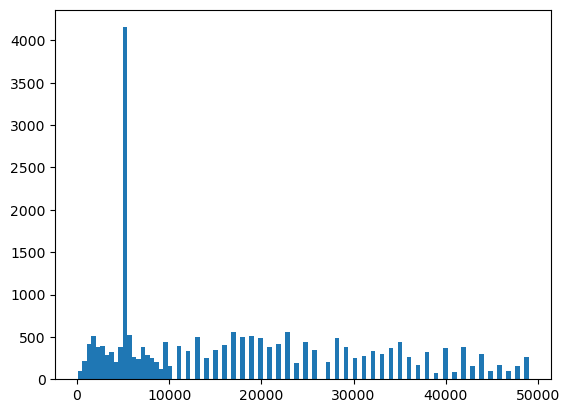

In [135]:
plt.hist(Data[(Data['AADT'] < 50000)]['AADT'].to_numpy(), bins = 100)

In [138]:
Data100s.drop(['Collision Report Number', 'Collision Date',
       'Jurisdiction', 'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number','Block Number'], axis =1 ).head()

,County,City,Associated State Road Number,Mile Post,School Zone,Intersection Related,Weather Condition,Lighting Condition,Injury Severity,Object Struck,Damage Threshold Met,Hit and Run,Motor Vehicles Involved,Passengers Involved,Commercial Carrier Involved,School Bus Involved,Pedestrians Involved,Pedalcyclists Involved,AADT
11108,Pierce,Fife,5.0,135.80,0,0,Clear,Dark-Street Lights On,No Injury Collision,NaN,1,0,2,0,0,0,0,0,204000.0
11323,King,Seattle,5.0,173.50,0,0,Clear,Daylight,No Injury Collision,NaN,1,0,2,0,0,0,0,0,190000.0
7753,Thurston,Lacey,5.0,114.00,0,0,Clear,Daylight,No Injury Collision,NaN,1,0,2,0,0,0,0,0,96000.0
6960,King,Seattle,5.0,166.62,0,0,Clear,Daylight,No Injury Collision,NaN,1,0,2,1,0,0,0,0,29000.0
10790,King,Federal Way,5.0,144.00,0,0,Clear,Daylight,No Injury Collision,NaN,1,0,3,0,0,0,0,0,159000.0


In [50]:
Data5400 = Data[(Data['AADT'] == 5400)]

In [51]:
len(Data5400)

3922

In [53]:
X_5400 = Data5400[['Associated State Road Number',"Injury Severity",'Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved']]
values = {"Lighting Condition": 'Unkown', "Weather Condition": 'Other', 'Passengers Involved':0.0, 'Commercial Carrier Involved':0.0,
       'School Bus Involved':0.0, 'Pedestrians Involved':0.0, 'Pedalcyclists Involved':0.0}
X_5400=X_5400.fillna(value=values)
X_5400=X_5400.dropna()

In [54]:
X_5400

,Associated State Road Number,Injury Severity,Intersection Related,Weather Condition,Lighting Condition,Passengers Involved,Commercial Carrier Involved,School Bus Involved,Pedestrians Involved,Pedalcyclists Involved
2,2.0,No Injury Collision,1,Overcast,Dark-Street Lights On,1,0,0,0,0
3,2.0,No Injury Collision,1,Overcast,Dark-Street Lights On,1,0,0,0,0
33,530.0,No Injury Collision,0,Overcast,Daylight,0,1,0,0,0
42,7.0,Unknown Injury Collision,0,Overcast,Dark-Street Lights On,0,0,0,0,0
43,7.0,Unknown Injury Collision,0,Overcast,Dark-Street Lights On,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
43328,26.0,No Injury Collision,1,Fog or Smog or Smoke,Daylight,0,0,0,0,0
43329,26.0,No Injury Collision,1,Fog or Smog or Smoke,Daylight,0,0,0,0,0
43336,530.0,Minor Injury Collision,0,Overcast,Daylight,0,0,0,0,0
43365,2.0,No Injury Collision,0,Raining,Dark-Street Lights On,0,0,0,0,0


In [169]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [0,7,2,3,5,4,0,6,1,8]
        states = X_5400['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = X_5400['Lighting Condition'].unique()
    for i in np.arange(X_5400[Condition].unique().shape[0]):
        X_5400.loc[X_5400[Condition] == states[i], Condition] = use_list[i]

In [170]:
X_5400 = X_5400[(X_5400["Injury Severity"] != "Unknown Injury Collision")]

In [171]:
X_5400["Injury Severity"].unique()

array(['No Injury Collision', 'Minor Injury Collision',
       'Serious Injury Collision', 'Fatal Collision'], dtype=object)

In [172]:
Y_5400 = Data[['Injury Severity']].iloc[X_5400.index.to_list()]
X_5400 = X_5400.drop(["Injury Severity"], axis = 1)

Number of mislabeled points out of a total 769 points : 290
0.6228868660598179
Confusion Matrix:
[[  0   1   2   0]
 [  1   5 171  31]
 [  0   0 470  67]
 [  1   1  15   4]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.00      0.00      0.00         3
  Minor Injury Collision       0.71      0.02      0.05       208
     No Injury Collision       0.71      0.88      0.79       537
Serious Injury Collision       0.04      0.19      0.07        21

                accuracy                           0.62       769
               macro avg       0.37      0.27      0.22       769
            weighted avg       0.69      0.62      0.56       769



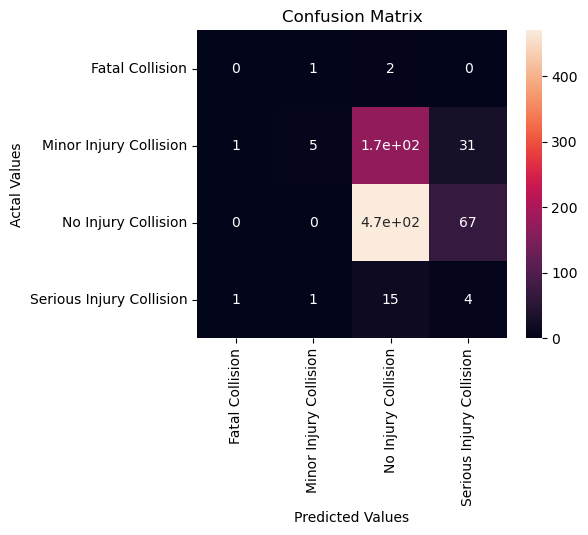

Predicted values:
Fatal Collision occurs 2 times
Minor Injury Collision occurs 7 times
No Injury Collision occurs 658 times
Serious Injury Collision occurs 102 times

Actual values:
Fatal Collision occurs 3 times
Minor Injury Collision occurs 208 times
No Injury Collision occurs 537 times
Serious Injury Collision occurs 21 times


In [176]:
PredictionReport(X_5400,Y_5400,"Multinomial")

In [221]:
R5400Data = Data5400[Data5400['County'].notna() 
                                    & Data5400['Weather Condition'].notna() 
                                    & Data5400['Lighting Condition'].notna()]
R5400Data["Associated State Road Number"] = R5400Data["Associated State Road Number"].astype(str)
R5400Data = R5400Data.join(pd.get_dummies(R5400Data[['Weather Condition','Lighting Condition', 
                                                     'County', 'Associated State Road Number']], dtype=float))
R5400Data = R5400Data[R5400Data["Injury Severity"] != "Unknown Injury Collision"]

In [222]:
R5400Data = R5400Data.drop(['County','Weather Condition','Lighting Condition',"Associated State Road Number",
        'Collision Report Number', 'Collision Date', 'City', 'Jurisdiction',
       'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number', 'Block Number',
                   'Object Struck', 'Damage Threshold Met', 'Hit and Run', 'Mile Post', 'AADT'], axis=1)

In [223]:
#Just finding between severe Injury or not
Regress5400Data = R5400Data.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 0,
                                  "Serious Injury Collision": 1, 
                                   'Fatal Collision': 1}})
R5400X = Regress5400Data

R5400X = R5400X.dropna()
R5400Y = R5400X['Injury Severity']
R5400X = R5400X.drop(['Injury Severity'], axis = 1)
R5400X_model = sm.add_constant(R5400X)
model = sm.OLS(R5400Y, R5400X_model)
results = model.fit()

In [224]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     12.49
Date:                Tue, 28 May 2024   Prob (F-statistic):          4.31e-106
Time:                        19:47:01   Log-Likelihood:                 1878.5
No. Observations:                3844   AIC:                            -3637.
Df Residuals:                    3784   BIC:                            -3262.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [49]:
results.coeff()

NameError: name 'results' is not defined